<b><u>RICE PREDICTIONS</u></b>
    
By Shawn Fu, Alice Shin, and Tú Vân

<b>Introduction:</b>

Rice is the most popular food crop grown in the world. Its popularity internationally is due to not only its role as a traditional foodstuff in many cultures, but also its versatility. Its many varieties are differentiated through flavour, colour, texture, and size, and in fact according to the UK's Rice Association there may be as many as 40 000 varieties of rice in the world.

In this project, we analyzed a dataset containing information about 3810 grains of rice. Each grain of rice was photographed and measured for a variety of physical dimensions. All of the rice grains belonged to one of two species: Cammeo, and Osmancik.

Our analysis aims to classify the rice in the dataset into these two species based on the other measured physical properties through a knn classification. Our classification will then be assessed for accuracy using metrics and a confusion matrix.

<b>Method:</b>

Run the following cell to load the required packages.

In [3]:
#Run this cell!

library(tidyverse)
library(repr)
library(readxl)
options(repr.matrix.max.rows = 6)
library(rvest)
library(rsample)
library(RCurl)
library(tidymodels)
library(ggplot2)
library(GGally)

Let's load in the data from the URL and use the glimpse function to take a look at the different measurements that were collected on the rice grains.

In [2]:
rice <- read_csv("https://raw.githubusercontent.com/alice-shin/DSCI100Project/main/Rice_Osmancik_Cammeo_Dataset.csv")
glimpse(rice)

Parsed with column specification:
cols(
  AREA = col_double(),
  PERIMETER = col_double(),
  MAJORAXIS = col_double(),
  MINORAXIS = col_double(),
  ECCENTRICITY = col_double(),
  CONVEX_AREA = col_double(),
  EXTENT = col_double(),
  CLASS = col_character()
)



Rows: 3,810
Columns: 8
$ AREA         <dbl> 15231, 14656, 14634, 13176, 14688, 13479, 15757, 16405, …
$ PERIMETER    <dbl> 525.579, 494.311, 501.122, 458.343, 507.167, 477.016, 50…
$ MAJORAXIS    <dbl> 229.7499, 206.0201, 214.1068, 193.3374, 211.7434, 200.05…
$ MINORAXIS    <dbl> 85.09379, 91.73097, 87.76829, 87.44839, 89.31245, 86.650…
$ ECCENTRICITY <dbl> 0.9288820, 0.8954050, 0.9121181, 0.8918609, 0.9066909, 0…
$ CONVEX_AREA  <dbl> 15617, 15072, 14954, 13368, 15262, 13786, 16150, 16837, …
$ EXTENT       <dbl> 0.5728955, 0.6154363, 0.6932588, 0.6406690, 0.6460239, 0…
$ CLASS        <chr> "Cammeo", "Cammeo", "Cammeo", "Cammeo", "Cammeo", "Camme…


After cleaning up the data, we begin our analysis by splitting the data into training and testing sets. 75% of the data will be used for training the model, with the rest used for testing. Since we are trying to figure out the species of rice, we are predicting for CLASS.

In [4]:
#Clean, Wrangling, and Exploring the Data

rice <- rice %>%
    mutate(CLASS = as_factor(CLASS))

#Creating train / test split

set.seed(1)
rice_split <- initial_split(rice, prop = 0.75, strata = CLASS)
rice_train <- training(rice_split)
rice_test <- testing(rice_split)

In the following table, we show the mean measurement for the species of rice in the dataset. This will allow us to gain a general understanding of how the two species differ.

In [6]:
rice_summary_by_class <- group_by(rice_train, CLASS)%>%
    summarize(
        area = mean(AREA),
        perimeter = mean(PERIMETER),
        majoraxis = mean(MAJORAXIS),
        minoraxis = mean(MINORAXIS),
        eccentricity = mean(ECCENTRICITY),
        convex_area = mean(CONVEX_AREA),
        extent = mean(EXTENT))
rice_summary_by_class

`summarise()` ungrouping output (override with `.groups` argument)



CLASS,area,perimeter,majoraxis,minoraxis,eccentricity,convex_area,extent
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cammeo,14154.65,487.2135,205.3067,88.78896,0.900838,14487.39,0.6511316
Osmancik,11535.21,429.1657,176.2292,84.39818,0.876432,11784.54,0.6702400


Table 1: Mean values for each explanatory variable grouped by CLASS

As we can see, grains of Cammeo rice are generally larger than grains of Osmancik rice. This difference is especially pronounced in the area and major axis length of the rice grains.

In the following table, we show the prevalence of each rice species in the dataset.

In [7]:
num_obs <- nrow(rice_train)
rice_train %>%
    group_by(CLASS)%>%
    summarize(
        n = n(),
        percentage = n() / num_obs*100)

`summarise()` ungrouping output (override with `.groups` argument)



CLASS,n,percentage
<fct>,<int>,<dbl>
Cammeo,1223,42.79216
Osmancik,1635,57.20784


Table 2: Number and percentage of observations by CLASS

As we can see, there are slightly more grains of Osmancik rice in the data set than Cammeo rice.

Now, let's scale the variables. Then, we will make plots of each variable and colour them by species.

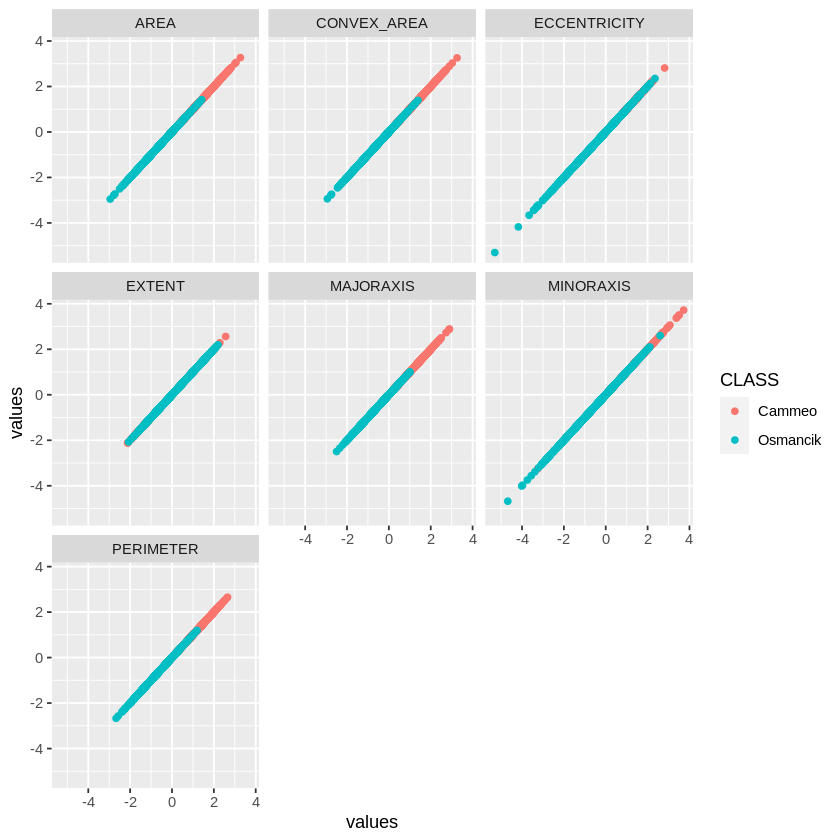

In [7]:
rice_scaled <-rice_train %>%
    select(-CLASS)%>%
    map(scale)%>%
    bind_cols()%>%
    mutate(CLASS = rice_train$CLASS)

rice_vis <- pivot_longer(rice_scaled, 
                        cols = AREA:EXTENT,
                        names_to = "variables",
                        values_to = "values")

ggplot(rice_vis, aes(x=values, y=values, color=CLASS))+
    geom_point()+
    facet_wrap(~variables)


Figure 1: Graph of standardized values plotted by explanatory variables and coloured by CLASS

As we can see, our earlier observations were correct. Cammeo rice grains are generally larger than Osmancik rice grains in every dimension.

Now, let's visualize the rice grains using a scatter plot matrix and visualize the correlation with multiple variables together.

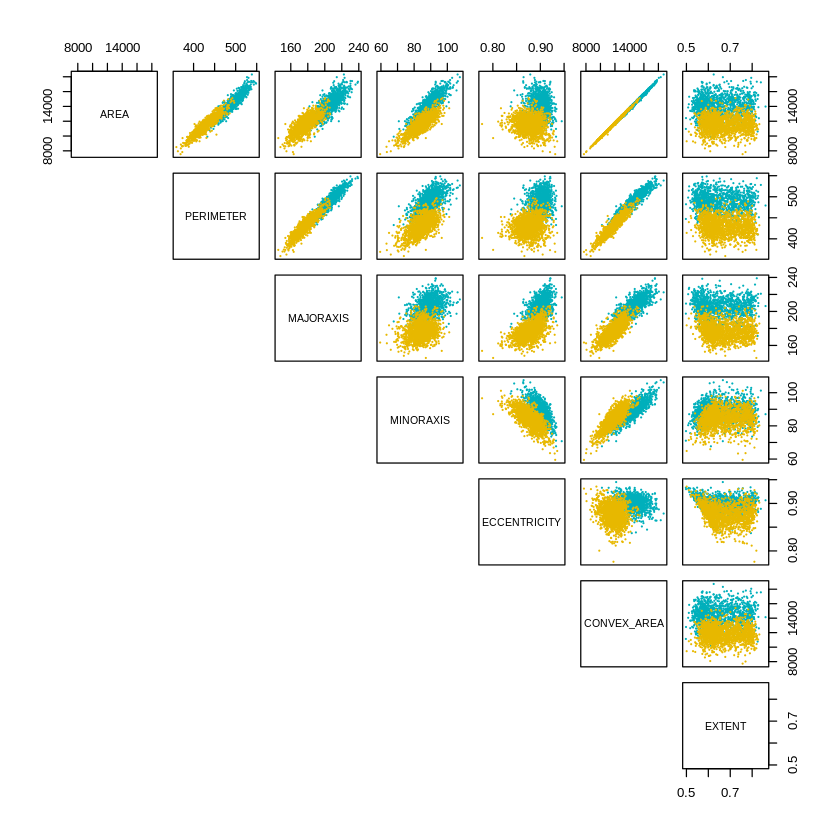

In [8]:
exp_vars <- rice_train %>%
    select(-CLASS)
my_cols <- c("#00AFBB", "#E7B800")
pairs(exp_vars, col = my_cols[rice_train$CLASS], lower.panel = NULL, cex=0.1)

Figure 2: Scatter plot matrix of explanatory variables coloured by CLASS

To get our analysis underway, we need to create our model. We first create our recipe, predicting class using all other variables in the training set. Next, we train the classifier, using the five nearest neighbours to predict the class of the rice grains. We then fit the data.

In [10]:
#Data pre-processing

rice_recipe <- recipe(CLASS ~., data = rice_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

#Training the classifier

set.seed(1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow()%>%
    add_recipe(rice_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = rice_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.08257523
Best kernel: rectangular
Best k: 5

We then tune the model using cross-validation. By doing so, we are able to choose the number of K-nearest neighbours that will give us the most accurate classification. 

We begin our cross-validation by splitting our training data into a subtraining and validation set, and get the accuracies for models using 1 to 5 K-nearest neighbours.

In [3]:
#Tune Using cross-validation
set.seed(2)


accuracies <- c()
for (i in 1:5) {
    set.seed(i)

    rice_split <- initial_split(rice_train, prop = 0.75, strata = CLASS)
    rice_subtrain <- training(rice_split)
    rice_validation <- testing(rice_split)
    
    rice_recipe <- recipe(CLASS ~., data = rice_subtrain)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors())
    
    knn_fit <- workflow()%>%
        add_recipe(rice_recipe)%>%
        add_model(knn_spec)%>%
        fit(data = rice_subtrain)
    
    validation_predicted <- predict(knn_fit, rice_validation)%>%
        bind_cols(rice_validation)
    
    acc <- validation_predicted %>%
        metrics(truth = CLASS, estimate = .pred_class)%>%
        filter(.metric =="accuracy")%>%
        select(.estimate)%>%
        pull()
    
    accuracies <- append(accuracies, acc)
}

accuracies


ERROR: Error in initial_split(rice_train, prop = 0.75, strata = CLASS): could not find function "initial_split"


In [11]:
rice_vfold <- vfold_cv(rice_train, v=5, strata=CLASS)

In [11]:
set.seed(1)

rice_recipe <- recipe(CLASS ~ ., data = rice_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit <- workflow() %>%
  add_recipe(rice_recipe) %>%
  add_model(knn_spec) %>%
  fit_resamples(resamples = rice_vfold)


In [12]:
knn_fit %>% collect_metrics()

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.9170729,5,0.004421614
roc_auc,binary,0.9565266,5,0.002474375


Table 3: Metrics of the classifer's validation accuracy across folds

We then make a graph of accuracy vs the number of K-nearest neighbours used, in order to choose the most accurate number of K-nearest neighbours.

In [4]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

set.seed(1)
k_lots <- tibble(neighbors = seq(from = 1, to = 100, by = 10))
knn_results <- workflow() %>%
  add_recipe(rice_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = rice_vfold, grid = k_lots) %>%
  collect_metrics()

accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k

ERROR: Error in nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% : could not find function "%>%"


Figure 3: Plot of accuracies vs. K

Since 62 is the number of neighbours that gets us the highest degree of accuracy, we use K=62 to train the classifier once again. Then, we run the classifier on the testing data.

In [12]:
#Choose K = 62
#Training the classifier

set.seed(1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 62) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow()%>%
    add_recipe(rice_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = rice_train)

knn_fit

#Predicting the test set

rice_test_predictions <- predict(knn_fit, rice_test)%>%
    bind_cols(rice_test)
rice_test_predictions




══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~62, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.07417775
Best kernel: rectangular
Best k: 62

.pred_class,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Cammeo,14688,507.167,211.7434,89.31245,0.9066909,15262,0.6460239,Cammeo
Cammeo,13500,476.915,202.5467,85.40547,0.9067549,13800,0.7177033,Cammeo
Cammeo,13509,480.466,207.1372,83.94016,0.9142106,13732,0.5956349,Cammeo
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Osmancik,9405,389.775,162.3682,74.43763,0.8887205,9594,0.6076366,Osmancik
Osmancik,11441,415.858,170.4868,85.75659,0.8642805,11628,0.6810119,Osmancik
Osmancik,11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,Osmancik


Table 4:Predictions of the test set

Finally, we use metrics and a confusion matrix to assess how successful our model was at predicting the species of the test data.

In [13]:
#Computing accuracy

rice_test_predictions %>%
    metrics(truth = CLASS, estimate = .pred_class)
rice_test_predictions %>%
    conf_mat(truth = CLASS, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9285714
kap,binary,0.8539858


          Truth
Prediction Cammeo Osmancik
  Cammeo      372       33
  Osmancik     35      512

Table 5: Metrics of the model
Table 6: Confusion matrix of the model